# NGC 6946 (The Fireworks galaxy)

Date: October 11, 2024. \
Location: Suburbs of Grenoble, France (Bortle 6/7). \
Material: Unistellar eQuinox 1 + UV/IR-cut filter. \
Darks: 225 x 4s. \
Lights: 1999 x 4s (~2h15).

Stacked with Siril / Gradient & Noise reduction with GraXpert / Photometry with Siril.

### WARNING: 
### To run this notebook, you need to install StarNet (star removal software available at https://www.starnetastro.com/). The starnet++ executable must be in the PATH.

### Import eQuimageLab and start dashboard:

In [1]:
import equimagelab as eqlab
dbrd = eqlab.Dashboard() # Start the dashboard.
import plotly.io as pio # Needed only to produce html documentation; may be removed.
pio.renderers.default = "png" # Needed only to produce html documentation; may be removed.

###########################################
# Welcome to eQuimageLab version 1.3.0... #
###########################################
Documentation available at: https://astro.ymniquet.fr/codes/equimagelab/docs/
Luma = 0.2127R+0.7152G+0.0722B.
Dash app running on http://127.0.0.1:8050/


### Set parameters:

In [2]:
eqlab.params.set_figure_max_width(800) # Max display width.
eqlab.params.set_image_sampling(1) # Image downsampling rate for display (reduces image resolution but speeds up display).

### Load FITS image from Siril + GraXpert:

In [3]:
original, meta = eqlab.load_image("NGC6946.fit")

Loading file NGC6946.fit...
Format = FITS.
Image size = 800x800 pixels.
Number of channels = 3.
Data type = >f4.
Bit depth per channel = 32.
Bit depth per pixel = 96.
Channel #0: minimum = 0.00008, maximum = 0.76050.
Channel #1: minimum = 0.00009, maximum = 0.63957.
Channel #2: minimum = -0.00000, maximum = 1.00000.
Succesfully read EXIF data...


### Remove stars with Starnet:

We will process the stars separately, so that they don't bloat too much when stretching...

In [4]:
starless, starmask = original.starnet(midtone = "auto", starmask = True)

Writing file /tmp/tmpufk16r0c/eQuimageLab.tiff with depth = 16 bpc...
Running StarNet++...
Reading input image... Done!
Bits per sample: 16
Samples per pixel: 3
Height: 800
Width: 800
Restoring neural network checkpoint... Done!
Total number of tiles: 16


2025-03-07 17:57:25.890580: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


100% finished

Done!
Reading file /tmp/tmpufk16r0c/eQuimageLab.tiff...


### Display "starless" image:

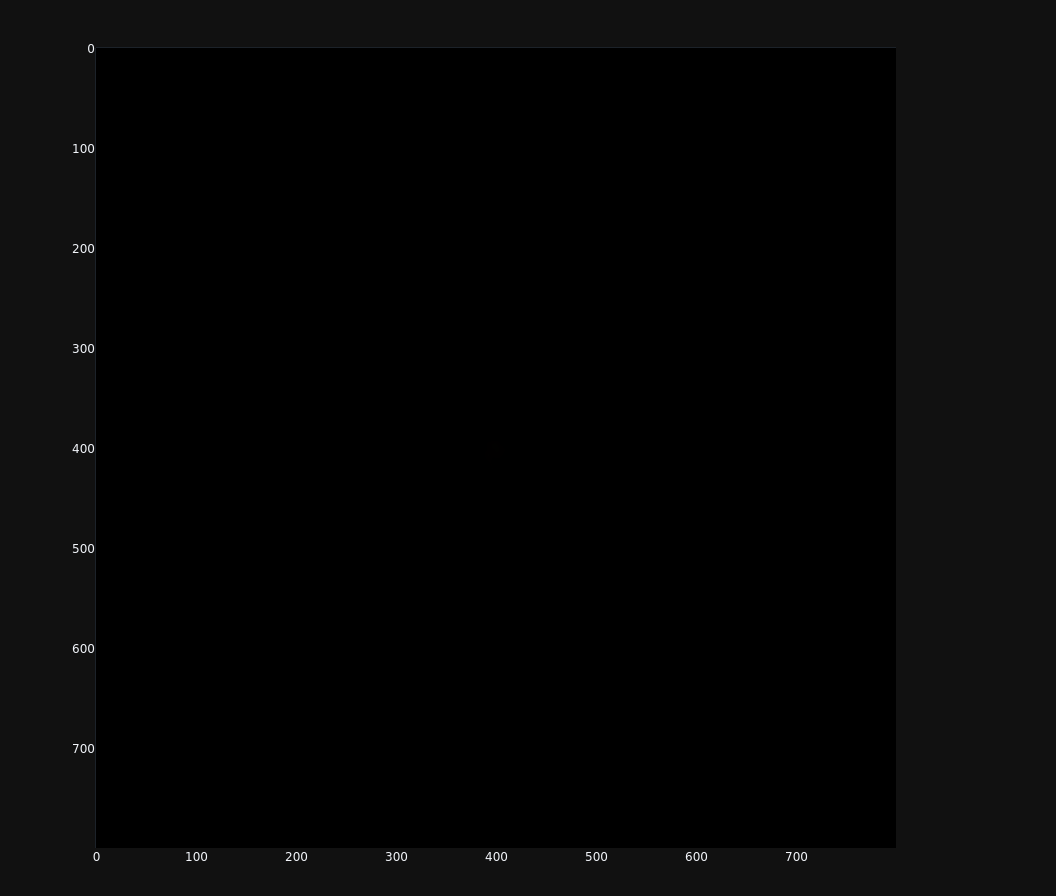

In [5]:
dbrd.show(starless, histograms = True, statistics = True)
eqlab.show(starless)

It's black ! The galaxy is hidden in the shadows, so let's...

### Stretch the starless:

We apply here a series of three generalized hyperbolic stretches to distribute contrast. We stretch the luma, in order to protect colors.

We start with a hard stretch (b = 10) to clear the galaxy:

In [6]:
stretched1 = starless.ghyperbolic_stretch(channels = "L", lnD1 = 5., b = 10., SYP = 0.00025)
dbrd.show_t(stretched1)

Then we fine tune contrast with softer stretches (b = 0):

In [7]:
# Leftover from tests, to illustrate the use of carousels !
# stretches = [stretched1.ghyperbolic_stretch(channels = "L", lnD1 = lnD1, b = 0., SYP = 0.05) for lnD1 in (1., 1.25, 1.5)]
# dbrd.carousel(stretches)

In [8]:
stretched2 = stretched1.ghyperbolic_stretch(channels = "L", lnD1 = 1.25, b = 0., SYP = 0.05)
dbrd.show_t(stretched2)

We use `channels = "Ls"` below, to regularize out-of-bounds pixels:

Maximum luma difference = 2.9802322443206464e-08.


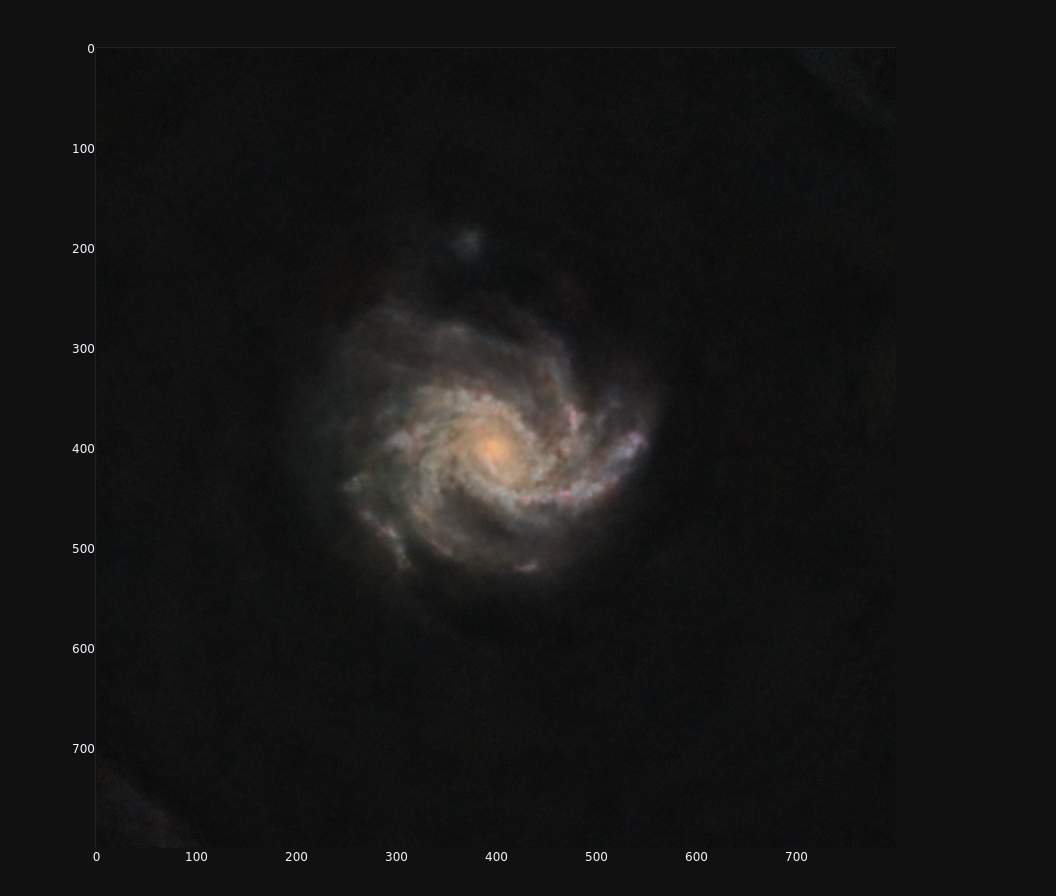

In [9]:
stretched3 = stretched2.ghyperbolic_stretch(channels = "Ls", lnD1 = 1.5, b = 0., SPP = .1, SYP = .45, HPP = .7)
dbrd.show_t(stretched3)
eqlab.show(stretched3)

### Set black point:

The background is very bright and noisy. \
Let's try to darken the background without loosing too much data (only few "shadowed" points in statistics):

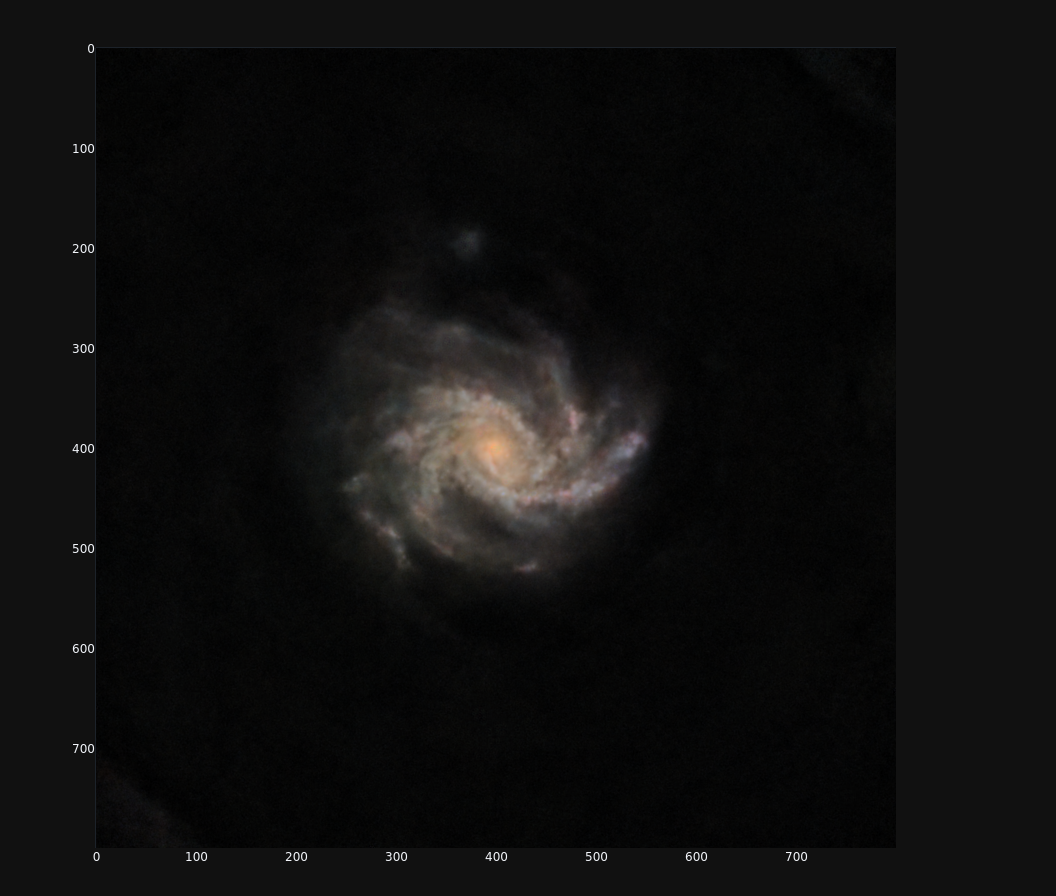

In [10]:
stretched = stretched3.set_black_point(channels = "L", shadow = 0.04)
dbrd.show_t(stretched)
eqlab.show(stretched)

### Denoise/enhance image:

Here is the most tricky part of the process !

One one hand, the background remains very noisy. This is the Poisson (photon counting) noise typical of low brightness areas. We may want to "blur" this background by applying a "low-pass" filter that softens small scale features - such as a convolution with a gaussian:

    blurred = stretched.gaussian_filter(sigma = 5.)

But that would also blur the galaxy !

On the other hand, the galaxy lacks sharpness... We may thus want, on the opposite, to apply a "high-pass" filter that enhances small scale features. Since the convolution with a gaussian is a low-pass filter, the following operation:

    sharpened = (1 + q) * stretched - q * blurred, q > 0

is a high-pass filter known as an "unsharp mask". We can also rewrite this filter as a conventional blend with a mixing coefficient m > 1:

    sharpened = (1 - m) * blurred + m * stretched, m > 1

But the unsharp mask would also enhance the noise in the background !

How can we tweak this operation to meet both requirements ? By making m dependent on the luma. Namely, we want m ~ 0 where the luma is "small" (the background), and m > 1 where the luma is "large" (the galaxy). So we may just try:

    m = a * stretched.luma()

where a > 1 controls image sharpening at large luma. In practice, we gain flexibility by stretching the luma to control how fast we switch from blurring to sharpening, e.g.:

    m = 2. * eqlab.mts(stretched.luma(), midtone = .15) # Here we switch from blurring to sharpening (m = 1) when luma = .15.

Finally, we apply these operations to a grayscale image in order to avoid "color spilling" when convoluting with the gaussian. We then reset the luma of the original image with the processed grayscale. 

So, let's first create a grayscale image from the luma of *stretched*:

In [11]:
l = stretched.grayscale(channel = "L")
dbrd.show((l, stretched), histograms = True, statistics = True)

And then blur this grayscale image by convoluting with a gaussian:

In [12]:
lblurred = l.gaussian_filter(sigma = 5.)
dbrd.show((lblurred, l))

We next blend l into lblurred with a l-dependent mixing.
The output grayscale image, lenhanced, is blurred at low brightness and sharpened at high brightness.
The parameters a and midtone must be tuned to balance blurring/sharpening.

In [13]:
a = 2.
midtone = .15
lenhanced = lblurred.blend(l, a*eqlab.mts(l, midtone = midtone))
dbrd.show((lenhanced, l))

Finally, we reset the luma of the original color image with lenhanced:

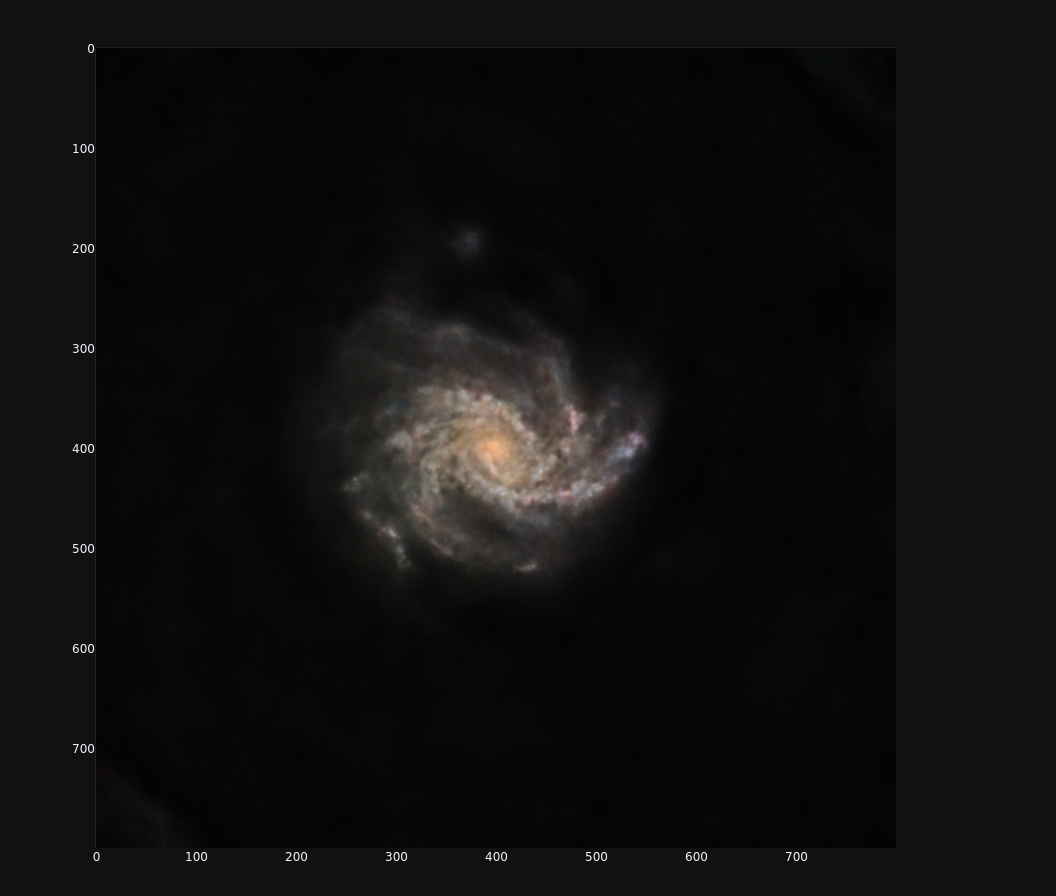

In [14]:
enhanced = stretched.set_channel("L", lenhanced.luma())
dbrd.show((enhanced, stretched), histograms = True, statistics = True)
eqlab.show(enhanced)

### Important note:

Starting from v1.1, this "light-dependent blur & sharpen" is directly available as:

    enhanced = stretched.LDBS(channel = "L", sigma = 5., amount = 1., threshold = .15)

### Clean fringes on the edges:

There are fringes in the corners that are artifacts of field rotation (due to the long, 2h15 exposure).

We will get rid of them by "unstretching" the corners; for that purpose we define a mask to protect the galaxy.

Be careful, the following command is rather long owing to the dilatation/smoothing of the mask (`extend = 300, smooth = 80`).

In [15]:
mask = eqlab.threshold_fmask(enhanced.filter(channel = "L", filter = "mean", radius = 32), threshold = .5, extend = 300, smooth = 80)

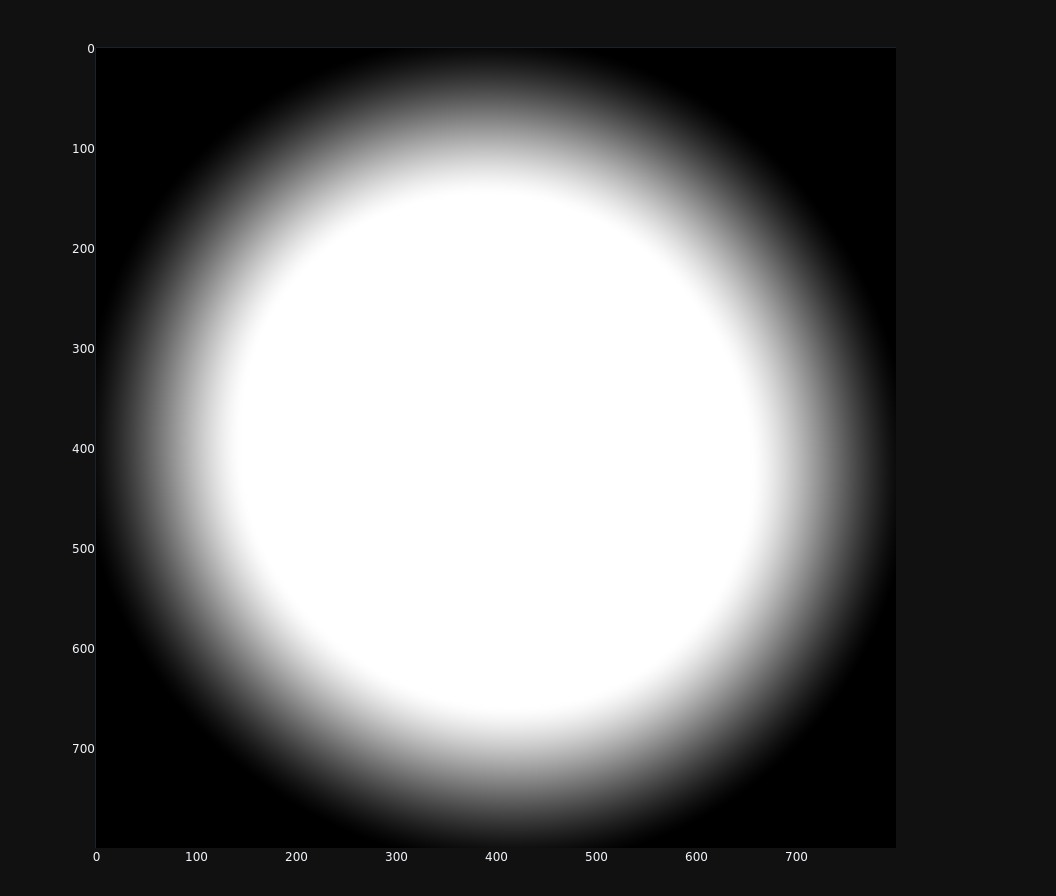

In [16]:
dbrd.show((mask, enhanced))
eqlab.show(mask)

We unstretch the whole image...

In [17]:
unstretched = enhanced.midtone_stretch(channels = "L", midtone = .25, inverse = True)
dbrd.show_t(unstretched)

...and blend with the original (*enhanced*) according to the mask.

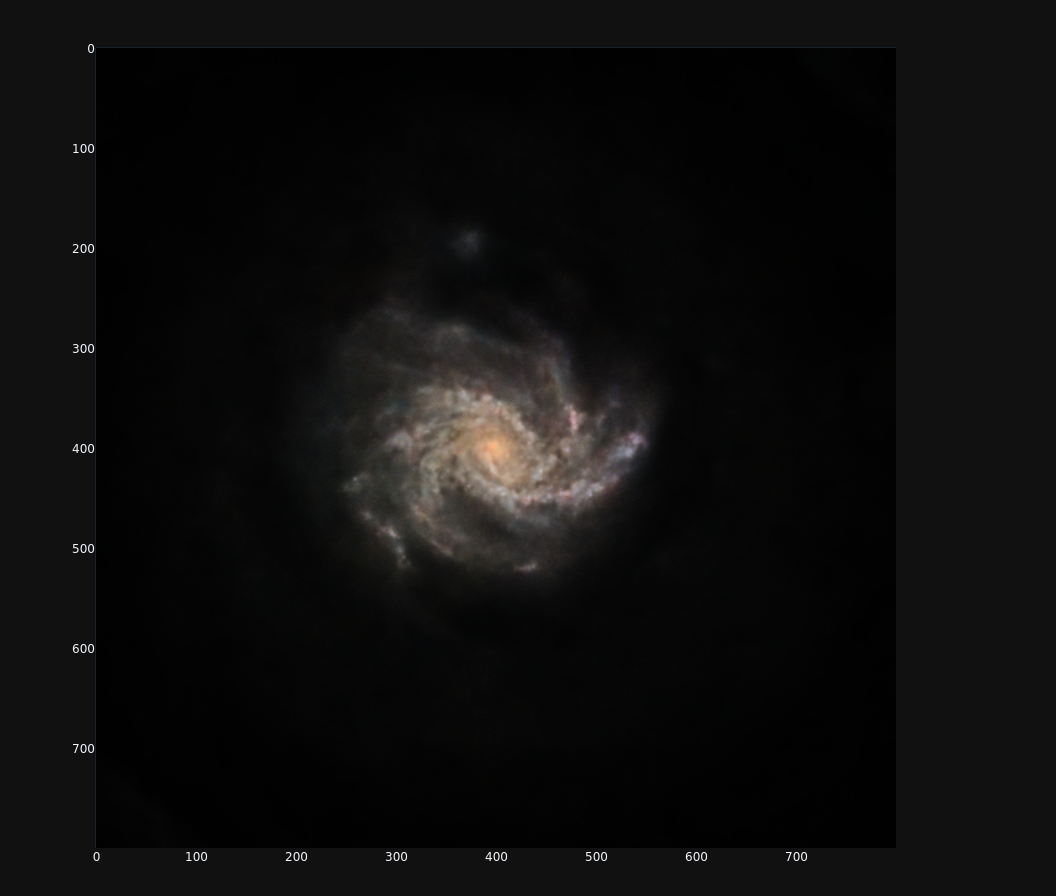

In [18]:
cleaned = unstretched.blend(enhanced, mask)
dbrd.show((cleaned, enhanced))
eqlab.show(cleaned)

### Stretch star mask:

Let's come back to the star mask... We apply a single generalized hyperbolic stretch to limit star bloating.

Maximum luma difference = 1.0187876642309135e-07.


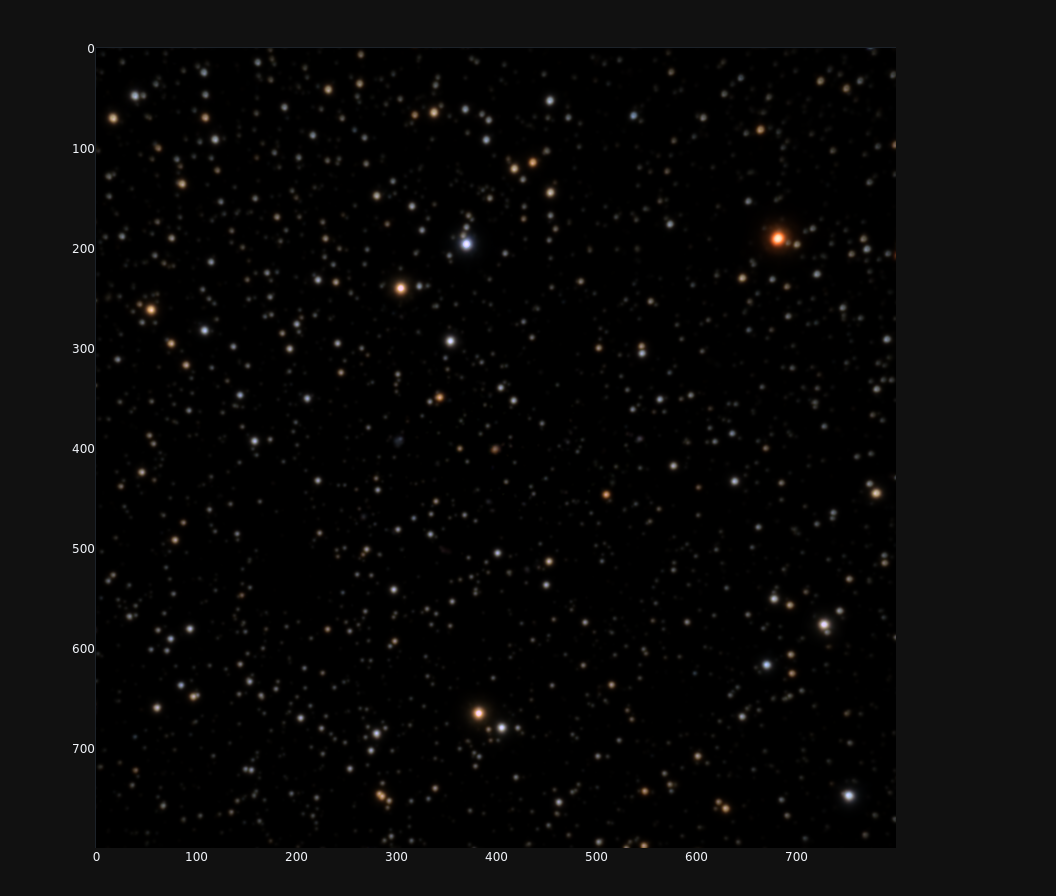

In [19]:
stretchedsm = starmask.ghyperbolic_stretch(channels = "Ls", lnD1 = 4., b = 10., SYP = 0.)
dbrd.show_t(stretchedsm)
eqlab.show(stretchedsm)

### Merge starless and star mask:

We now merge the processed starless and star mask using a so-called "screen" blend.

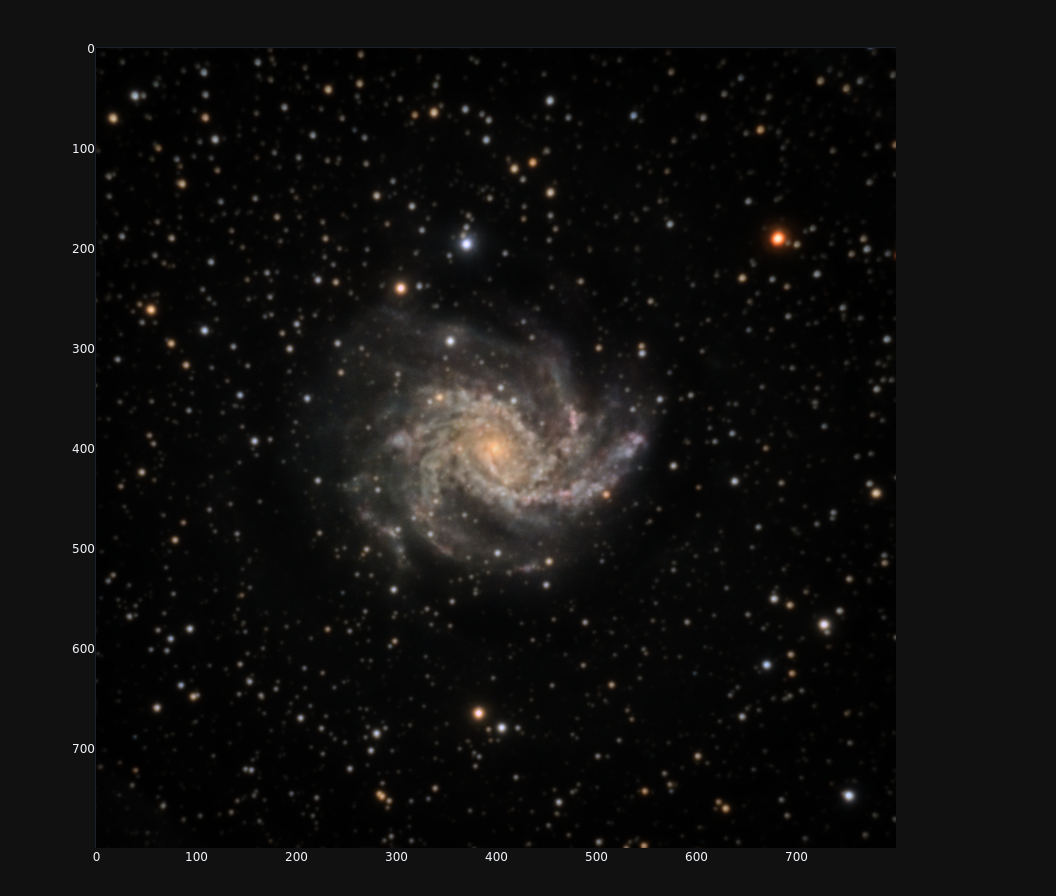

In [20]:
merged = 1.-(1.-cleaned)*(1.-stretchedsm) # Screen blend.
dbrd.show(merged, histograms = True, statistics = True)
eqlab.show(merged)

### Rescale image:

We double the resolution of the final image to avoid excessive pixelisation if the renderer does not accurately upscale the images.

In [21]:
final = merged.rescale(2.)
print(final)

Image(size = 1600x1600 pixels, colorspace = sRGB, colormodel = RGB, type = float32)


### Save image:

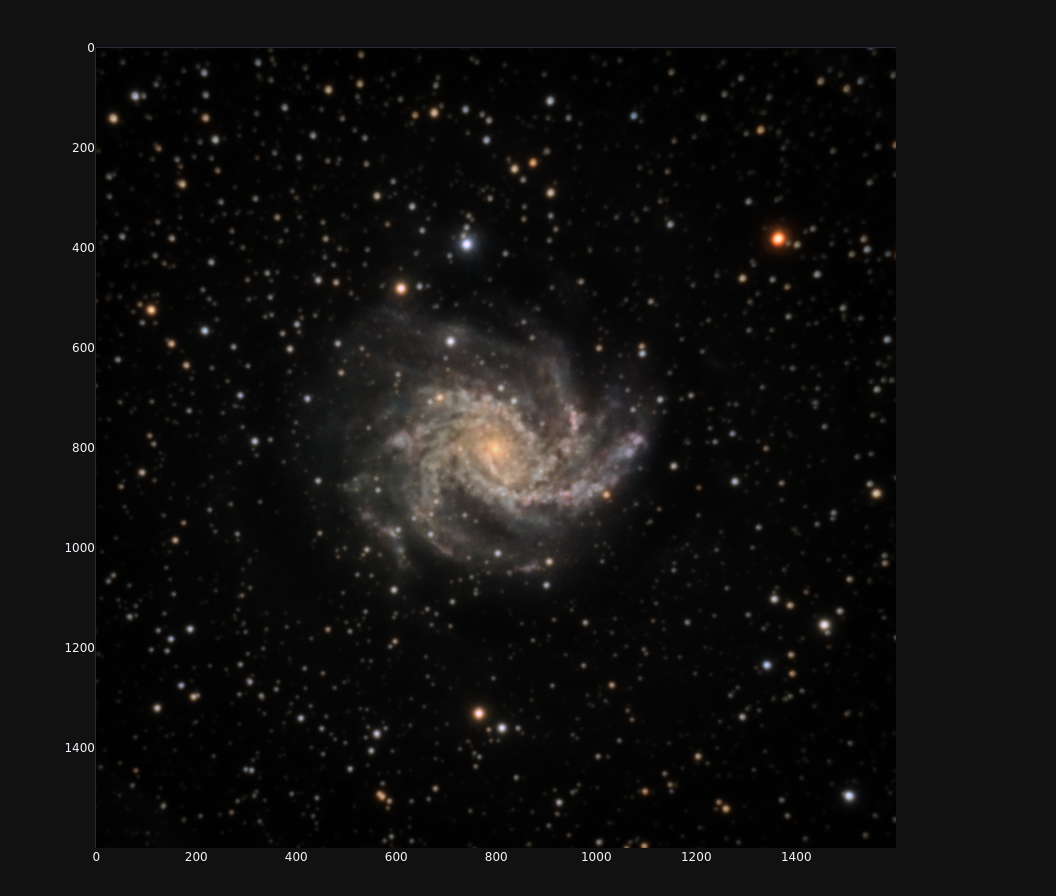

Saving RGB image as file NGC6946.png...
Color depth = 8 bits integer per channel.


In [22]:
dbrd.show(final)
eqlab.show(final)
final.save("NGC6946.png")

Done !